In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy
from metpy.units import units
import metpy.calc as mpcalc
import math
import datetime as dt

import sys
sys.path.append('/Users/clintonalden/Documents/Research/summa_work/')
from utils import lw_clr
from utils import forcing_filler as ff


In [36]:
# Read in csv data from Harts Pass SNOTEL
# Subset after October 17 as the data is poor before then
harts = pd.read_csv('samw1_met_WY22.csv')

# Load template forcing file with correct attributes
template = xr.open_dataset('../summa_forcing_template.nc')

# Pull in only necessary columns and rename to match SUMMA formatting
harts = harts[['Date_Time', 'air_temp_set_1', 'precip_accum_set_1']]
replace = {'air_temp_set_1':'airtemp', 'precip_accum_set_1':'accppt', 'Date_Time':'time'}
harts.rename(columns=replace, inplace=True)

# Convert 'time' column to datetime format
harts['time'] = pd.to_datetime(harts['time'])

# Convert time column to desired format
harts['time'] = harts['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Remove bad data/station maintenance before October 15
harts.loc[harts['time'] < '2021-10-15', 'accppt'] = 0

harts = harts.interpolate(method='linear')

# Use cummax to fix the issues with SNOTEL hourly data
harts['accppt'] = harts['accppt'].cummax()

# Convert precip from mm hr-1 to kg m-2 s-1
harts['pptrate'] = harts['accppt'].diff()/3600

# Generate relative humidity assuming T_d is overnight low temperature
ff.fill_rel_hum(harts)

# Convert temperature from C to K
harts['airtemp'] = harts['airtemp'] + 273.15

# Set NaN precip values to 0
harts['pptrate'] = harts['pptrate'].fillna(0)

# Generate pressure from hypsometric equation and site elevation (1981m)
ff.fill_pressure(harts, 1981)

# Generate specific humidity
ff.fill_spec_hum(harts)

# Generate longwave radiation
harts['LWRadAtm'] = lw_clr.dilleyobrien1998(harts['airtemp'], harts['rh'])

# Set time as index
harts.set_index('time', inplace=True)
harts.index = pd.to_datetime(harts.index)

# Save to csv with precip cleaned for generating radiation data with metsim
# accppt is kept for metsim
harts.to_csv('salmon_cleaned_WY22.csv')

# Drop unnecessary columns
# harts = harts.drop(columns=['accppt', 'rh'])



/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_72705/1327065989.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  harts = harts.interpolate(method='linear')


<Axes: xlabel='time'>

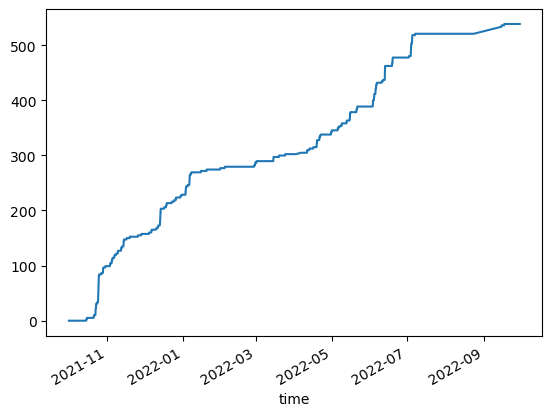

In [37]:
harts.accppt.plot()

In [3]:
# Convert dataframe to xarray
dsx = harts.to_xarray()

# Loop through variables and add attributes from template forcing file
for data_var in dsx:
    dsx[data_var].attrs = template[data_var].attrs
    
# Add hru dimension
dsx = dsx.expand_dims(dim={'hru':1})

# Add gap-filled and datastep variables
dsx['gap_filled'] = xr.DataArray(np.ones((1,dsx.time.shape[0])),dims = ['hru','time'])
dsx['data_step'] = 3600 # 3600 seconds for 1hr timesteps

# Transpose gap filled variable to match dimensions with the rest
# dsx['gap_filled'] = dsx['gap_filled'].T

# Convert all to float64
for var in dsx.data_vars:
    dsx[var] = dsx[var].astype(np.float64)

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.int32)

# Transpose all variables to match SUMMA dimensions
count = 0
for var in dsx.data_vars:
    print(var,count)
    count += 1
    if count <= 7:
        attribs = dsx[var].attrs
        arr_t = dsx[var].values.T
        dsx[var] = xr.DataArray(dims = ['time','hru'],data = arr_t)
        dsx[var].attrs = attribs

# Set encoding for the time variable
# dsx['time'].encoding = {'_FillValue': np.nan, 'units': 'hours since 1990-01-01', 'calendar': 'proleptic_gregorian'}

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.float64).fillna(0).astype(np.int32)

# Save to netcdf
dsx.to_netcdf('./harts_SNTL_WY24.nc',
              engine='h5netcdf')

airtemp 0
windspd 1
SWRadAtm 2
pptrate 3
airpres 4
spechum 5
LWRadAtm 6
gap_filled 7
data_step 8
hruId 9


In [4]:
dsx


<xarray.Dataset> Size: 260kB
Dimensions:     (time: 3607, hru: 1)
Coordinates:
  * time        (time) datetime64[ns] 29kB 2023-10-17 ... 2024-03-15T12:00:00
Dimensions without coordinates: hru
Data variables:
    airtemp     (time, hru) float64 29kB 277.6 276.2 276.0 ... 276.3 275.8 276.0
    windspd     (time, hru) float64 29kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWRadAtm    (time, hru) float64 29kB 53.66 4.68 3.81 3.81 ... 3.81 3.81 3.81
    pptrate     (time, hru) float64 29kB 0.0 0.001411 0.0 0.0 ... 0.0 0.0 0.0
    airpres     (time, hru) float64 29kB 8.71e+04 8.703e+04 ... 8.702e+04
    spechum     (time, hru) float64 29kB 0.005594 0.005401 ... 0.004635 0.004653
    LWRadAtm    (time, hru) float64 29kB 255.0 250.2 248.8 ... 245.6 243.8 244.7
    gap_filled  (hru, time) float64 29kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    data_step   float64 8B 3.6e+03
    hruId       (hru) int32 4B 1001

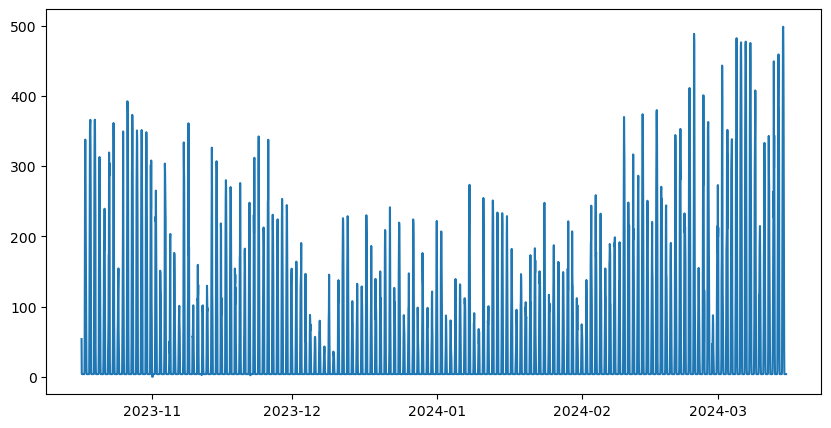

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(harts.index, harts['SWRadAtm'], label='SWRadAtm')